In [2]:
%matplotlib notebook

import os
import glob
import imageio

from math import atan2, degrees

import numpy as np
import pandas as pd

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import ListedColormap

from scipy.ndimage import gaussian_filter

# Plot hetmaps over selected frame without data from rejected sessions.

In [3]:
DISPLAY_SIZE = (320,200)
extent = [0, DISPLAY_SIZE[0], DISPLAY_SIZE[1], 0]

cmap = cm.jet
my_cmap = cmap(np.arange(cmap.N))
# Set alpha
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)
# Create new colormap
cm_jet = ListedColormap(my_cmap)

def visual_span_from_distance(distance, size=5, scale=1):
    h = 324 / scale # Monitor height in cm
    d = distance / scale # Distance between monitor and participant in cm
    r = 800 / scale # Vertical resolution of the monitor
    size_in_deg = size # The stimulus size in pixels
    # Calculate the number of degrees that correspond to a single pixel. This will
    # generally be a very small value, something like 0.03.
    deg_per_px = degrees(atan2(.5*h, d)) / (.5*r)
    # Calculate the size of the stimulus in degrees
    size_in_px = size_in_deg / deg_per_px
    return size_in_px

def normalize(data):
    return ( data - data.min() ) / ( data.max() - data.min() )

def get_data(mediafile):
    media = imageio.get_reader("../Dataset/Mahnob/data/media_24/{}.avi".format(mediafile))
    valence_data = pd.DataFrame.from_csv("data/valence_data_for_heatmap_creation_{}.csv".format(mediafile)).applymap(eval)
    arousal_data = pd.DataFrame.from_csv("data/arousal_data_for_heatmap_creation_{}.csv".format(mediafile)).applymap(eval)
    return media, valence_data, arousal_data

def get_media_frame(media, frames):
    images = []
    for frame in frames:
        media.set_image_index(frame-1)
        images.append(media.get_next_data())
    return images

def get_frame_coordinates(coord, frames):
    frame_coordinates = []
    for frame in frames:
        frame_coordinates.append(coord.T[frame-1])
    return frame_coordinates

def get_frame_fixations(fix, frames):
    frame_fixations = []
    for frame in frames:
        frame_fixations.append(fix.T[frame-1])
    return frame_fixations

def create_image_from_fixation(x, y, v, distance=None, size=5):
    m = np.zeros([DISPLAY_SIZE[1], DISPLAY_SIZE[0]], dtype=float)
    m[int(y), int(x)] = v
    
    if distance is None:
        sigma = 12
    else:
        sigma = 0.17 * visual_span_from_distance(distance, size=size, scale=4)
    
    m = gaussian_filter(m, sigma=sigma)
    return m

def compute_frame_saliency_map(data):
    ## matrix of zeros
    M = np.zeros([DISPLAY_SIZE[1], DISPLAY_SIZE[0]], dtype=float)
    # gaussian matrix
    for x, y, duration, distance, _ in data:
        if 0<=x<=DISPLAY_SIZE[0] and 0<=y<=DISPLAY_SIZE[1]:
            m = create_image_from_fixation(x, y, v=duration, distance=distance, size=10)
            M = np.add(M, m)
    return M

def compute_frame_emotion_saliency_map(data):
    ## matrix of zeros
    M = np.zeros([DISPLAY_SIZE[1], DISPLAY_SIZE[0]], dtype=float)
    # gaussian matrix
    for x, y, duration, distance, feature in data:
        if 0<=x<=DISPLAY_SIZE[0] and 0<=y<=DISPLAY_SIZE[1]:
            m = create_image_from_fixation(x, y, v=feature, distance=distance, size=12)
            M = np.add(M, m)
    return M

def get_frame_saliency_maps(gaze_data, frames):
    frame_saliency_maps = []
    
    for frame in frames:
        gd = gaze_data.T[frame]
        frame_saliency_maps.append(compute_frame_saliency_map(gd))
        
    frame_saliency_maps = np.array(frame_saliency_maps)
    
    # apply normalization to get the information of the relation with other heatmaps
    frame_saliency_maps = normalize(frame_saliency_maps)
    
    # apply some threashold to remove usesell peak
    frame_saliency_maps[frame_saliency_maps<=.2] = 0
    
    return frame_saliency_maps

def get_frame_emotion_saliency_maps(gaze_data, frames):
    frame_saliency_maps = []
    
    for frame in frames:
        gd = gaze_data.T[frame]
        frame_saliency_maps.append(compute_frame_emotion_saliency_map(gd))    
    
    frame_saliency_maps = np.array(frame_saliency_maps)
    
    # apply normalization to get the information of the relation with other heatmaps
    frame_saliency_maps = normalize(frame_saliency_maps)
    
    # apply some threashold to remove usesell peak
    frame_saliency_maps[frame_saliency_maps<=.2] = 0
    return frame_saliency_maps

##
## PLOT FUNCTIONS
##

def create_axes(sub=(1,1)):
    
    dpi = 100
    ncols=sub[0]
    nrows=sub[1]
    # determine the figure size in inches
    figsize = (1280*ncols/dpi, 800*nrows/dpi)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, dpi=dpi)
    
    extent = [0, DISPLAY_SIZE[0], DISPLAY_SIZE[1], 0]

    if not isinstance(axes, type(np.array)): 
        axes = np.array(axes) 
    
    for ax in axes.flatten(): 
        ax.axis(extent)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    return fig, axes.flatten()

def plot_images(axes, frames):
    images = get_media_frame(media, frames)
    for ax, im in zip(axes, images):
        ax.imshow(im, origin='lower')
    
def plot_coordinates(axes, data, frames, retax=False):
    frame_coordinates = get_frame_coordinates(data, frames)
    for ax, coord in zip(axes, frame_coordinates):
        for c in coord:
            x, y, _, _, _ = c
            ax.scatter(x, y, s=10, alpha=.8, c='cyan')

def plot_fixations(axes, data, frames):
    frame_fixations = get_frame_fixations(data, frames)
    for ax, fix in zip(axes, frame_fixations):
        for f in fix:
            x, y, d, distance, _ = f
            ax.scatter(x, y, s=1e-2*d, alpha=.8, c='orange')
            r = 0.17 * visual_span_from_distance(distance, scale=4)
            circle = plt.Circle((x, y), r, alpha=.8, color='orange', fill=False)
            ax.add_artist(circle)
        
def plot_saliency_map(axes, data, frames):
    frame_saliency_maps = get_frame_saliency_maps(data, frames)
    for ax, heatmap in zip(axes, frame_saliency_maps):
        ax.imshow(heatmap, extent=extent, cmap=cm_jet, vmin=0, vmax=1, alpha=.8)

def plot_emotion_saliency_map(axes, data, frames):
    frame_saliency_maps = get_frame_emotion_saliency_maps(data, frames)
    for ax, heatmap in zip(axes, frame_saliency_maps):
        ax.imshow(heatmap, extent=extent, cmap=cm_jet, vmin=0, vmax=1, alpha=.8)

In [3]:
mediafile = 30
media, valence_data, arousal_data = get_data(mediafile)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls


In [4]:
frames = [10]
col = 1
#axes = create_axes((col,len(frames)//col))
#plot_images(axes, frames)
#plot_coordinates(axes, coordinates, frames)

<IPython.core.display.Javascript object>


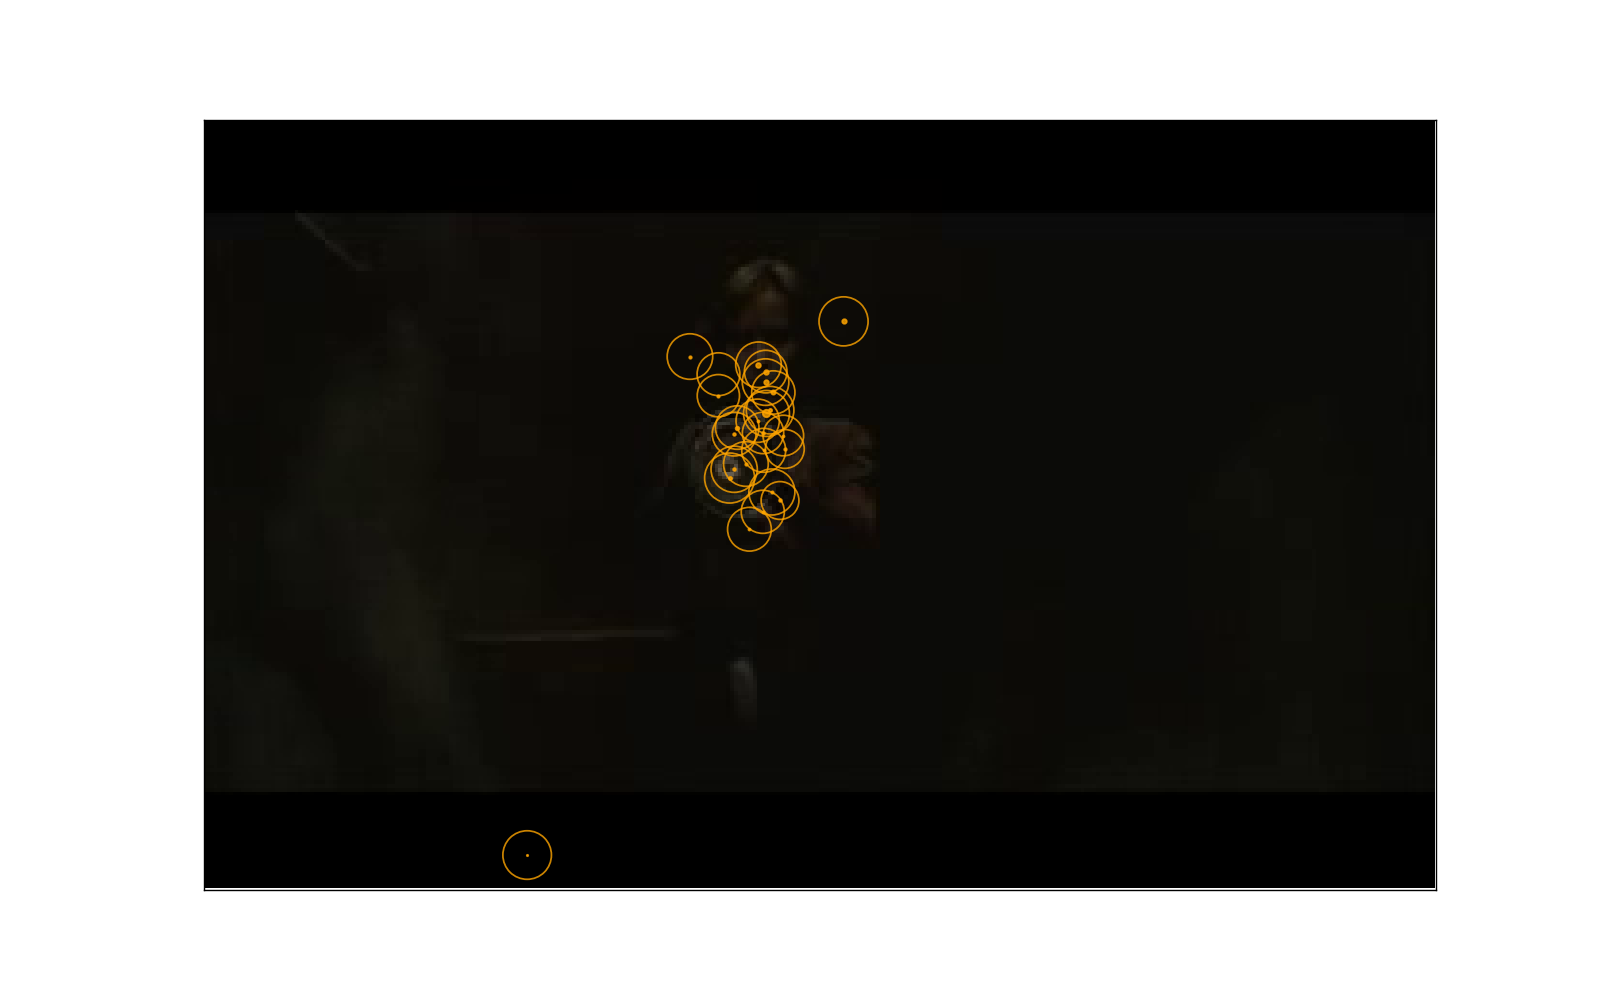

/opt/conda/lib/python3.6/site-packages/matplotlib/collections.py:902: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


In [5]:
plt.ioff()
fig, axes1 = create_axes((col,len(frames)//col))
plot_images(axes1, frames)
plot_fixations(axes1, valence_data, frames)

<IPython.core.display.Javascript object>


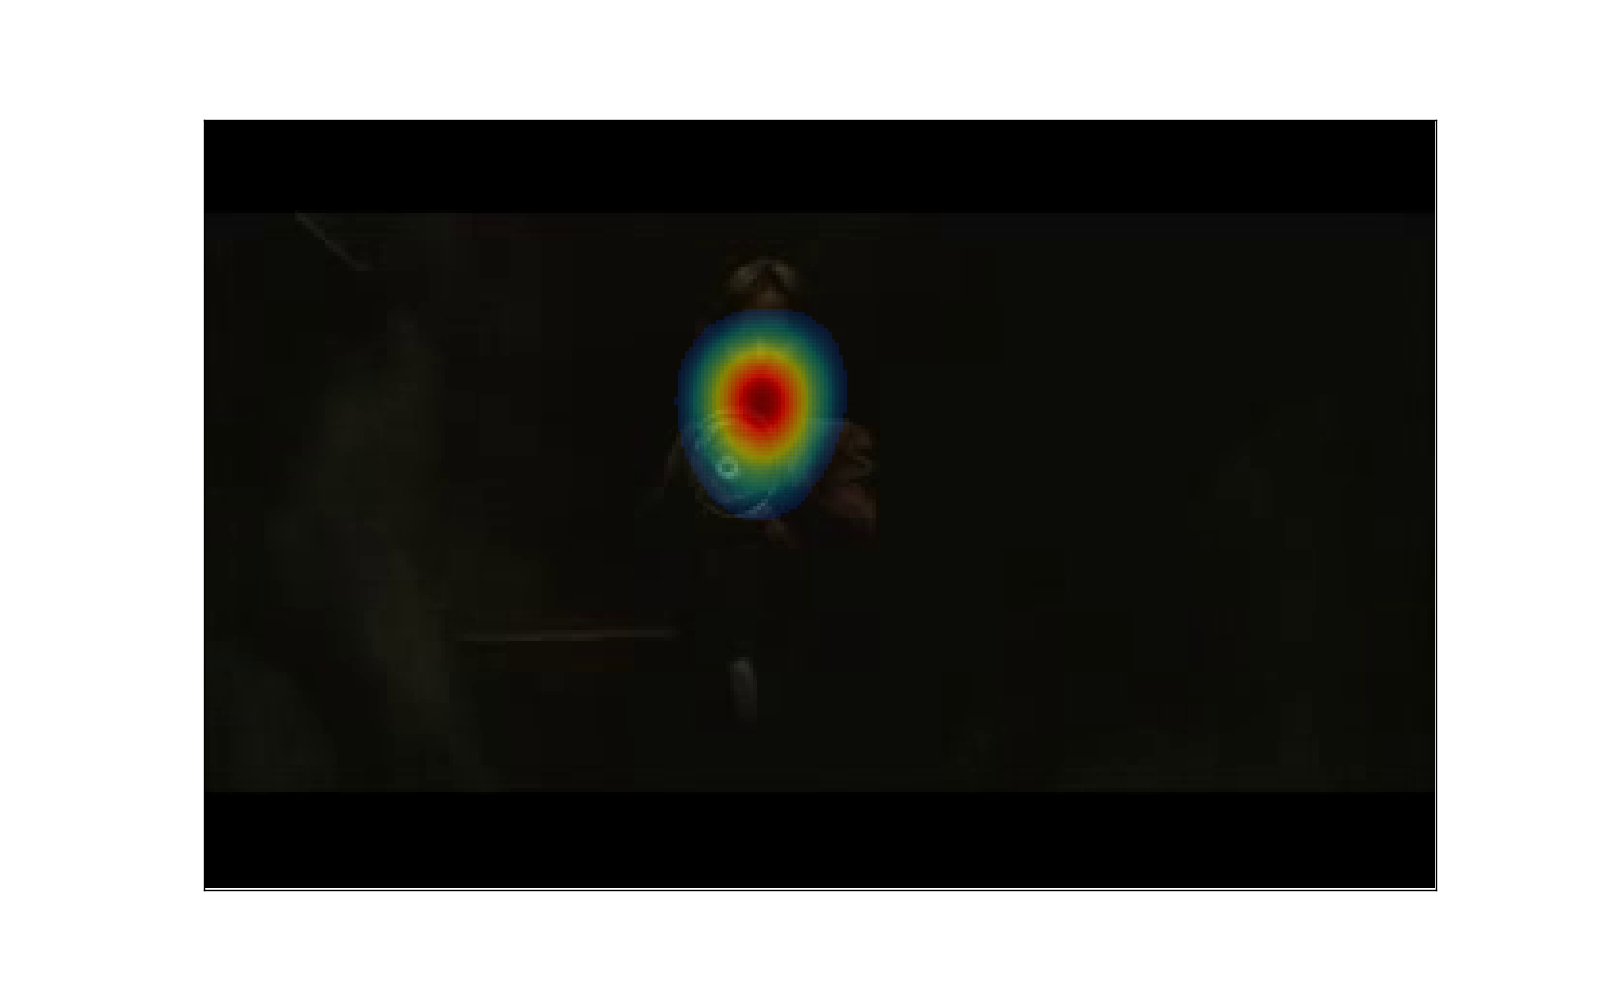

In [6]:
plt.ioff()
fig, axes = create_axes((col,len(frames)//col))
plot_images(axes, frames)
plot_saliency_map(axes, valence_data, frames)

<IPython.core.display.Javascript object>


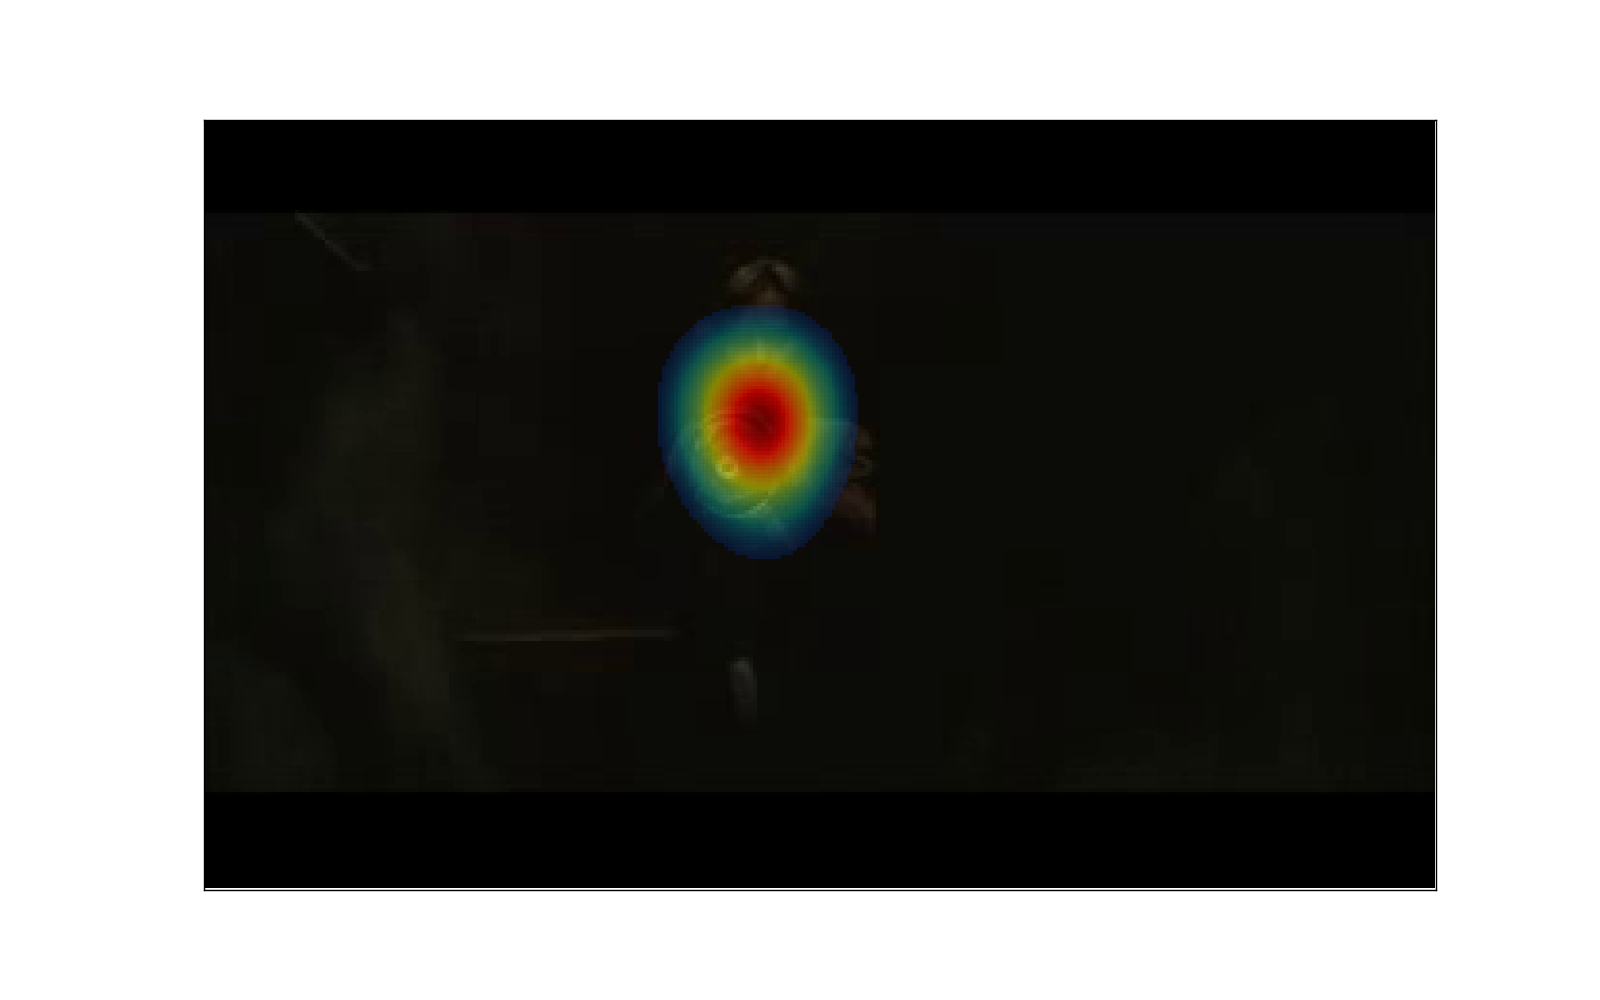

In [7]:
plt.ioff()
fig, axes = create_axes((col,len(frames)//col))
plot_images(axes, frames)
plot_emotion_saliency_map(axes, valence_data, frames)

<IPython.core.display.Javascript object>


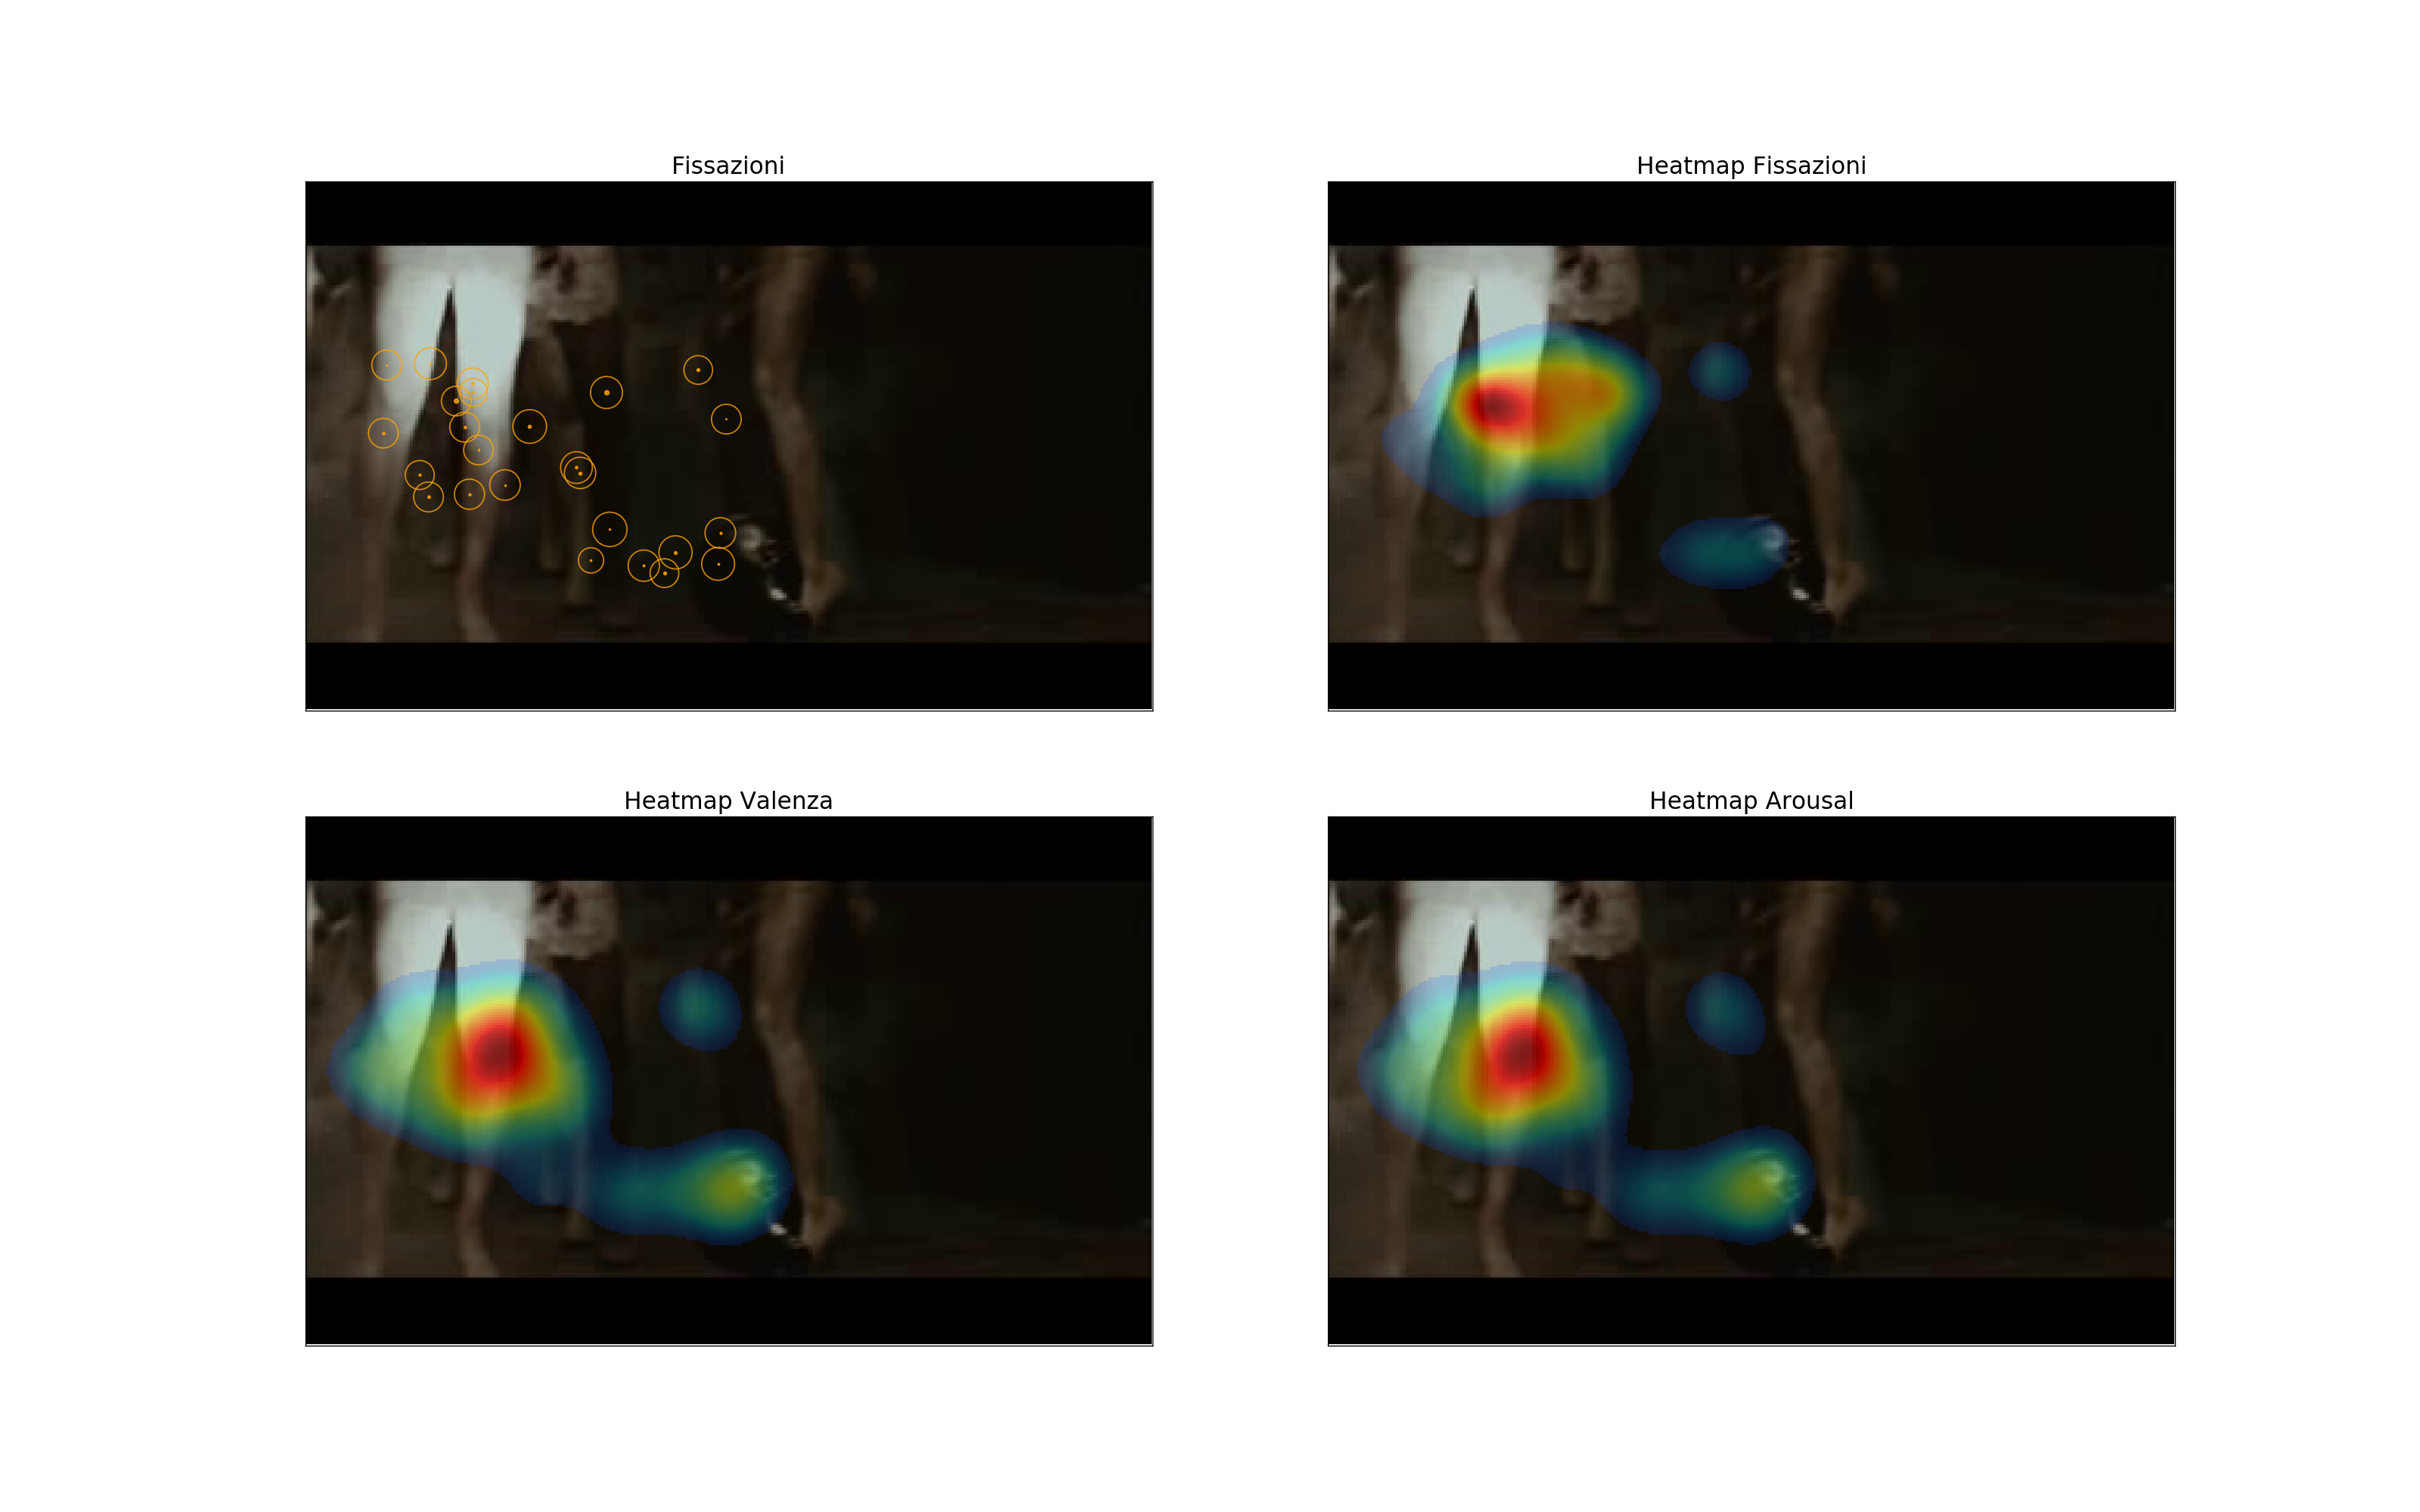

In [8]:
plt.ioff()
frames = [1600]

fig, axes = create_axes((2,2))
plot_images([axes[0]], frames)
plot_images([axes[1]], frames)
plot_images([axes[2]], frames)
plot_images([axes[3]], frames)


plot_fixations([axes[0]], valence_data, frames)
plot_saliency_map([axes[1]], valence_data, frames)
plot_emotion_saliency_map([axes[2]], valence_data, frames)
plot_emotion_saliency_map([axes[3]], arousal_data, frames)

for ax, title in zip(axes, ['Fissazioni', 'Heatmap Fissazioni', 'Heatmap Valenza', 'Heatmap Arousal']):
    ax.set_title(title, fontdict={'fontsize': 18})

In [4]:
mediafile = 53
media, valence_data, arousal_data = get_data(mediafile)
nframes = media.get_meta_data()['nframes']

plt.ioff()
for frame in range(1, nframes+1, 100):
    
    f = [frame]
    fig, axes = create_axes((2,2))
    
    plot_images([axes[0]], f)
    plot_images([axes[1]], f)
    plot_images([axes[2]], f)
    plot_images([axes[3]], f)

    plot_fixations([axes[0]], valence_data, f)
    plot_saliency_map([axes[1]], valence_data, f)
    plot_emotion_saliency_map([axes[2]], valence_data, f)
    plot_emotion_saliency_map([axes[3]], arousal_data, f)

    for ax, title in zip(axes, ['Fissazioni', 'Heatmap Fissazioni', 'Heatmap Valenza', 'Heatmap Arousal']):
        ax.set_title(title, fontdict={'fontsize': 34}, pad=12)
    
    fig.savefig("img/{}_{}.png".format(mediafile, frame), format='png')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
